In [ ]:
!nvidia-smi

Wed May  4 04:32:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/vessel_segmentation

/content/drive/MyDrive/vessel_segmentation


In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 3.7 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

K.set_image_data_format('channels_last')

def jacard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_pred_f = tf.cast(y_pred_f, tf.float32)
    y_true_f = tf.cast(y_true_f, tf.float32)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)
    return intersection/union

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_pred_f = tf.cast(y_pred_f, tf.float32)
    y_true_f = tf.cast(y_true_f, tf.float32)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return - dice_coef(y_true, y_pred)

## MultiResUNet

```python
def step_decay(epoch):
   initial_lrate = LRATE
   drop = 0.5
   epochs_drop = 10.0 # drop lr by half every 10 epochs
   lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
   return lrate

lr_scheduler = LearningRateScheduler(step_decay)
```

In [ ]:
from model.MultiResUNet import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from generator import *
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
sess = tf.compat.v1.Session(config=config)
plot_history = []

IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

EPOCHS = 60
LOSS = 'dice_coef_loss'
OPT = 'adam'
MOMENTUM = 0.9

train_dataset = './data/artery/train_artery.h5'
valid_dataset = './data/artery/valid_artery.h5'
BATCH_SIZE = 4

train_gen = DatasetGenerator(dataset_path=train_dataset,batch_size=BATCH_SIZE)
TOTAL = train_gen.getNumberOfTotalImages()
train_epoch = train_gen.generator()

valid_gen = DatasetGenerator(dataset_path=valid_dataset,batch_size=BATCH_SIZE)
TOTAL_VAL = valid_gen.getNumberOfTotalImages()
valid_epoch = valid_gen.generator()

steps_per_epoch = int(TOTAL / BATCH_SIZE)
cycles_n = 25
step_size = EPOCHS * steps_per_epoch / (cycles_n*2)
LRATE = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-5,
                                            maximal_learning_rate=1e-2,
                                            step_size=step_size,
                                            scale_fn=lambda x: 1.0)

model = MultiResUNet(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

loss_func = dice_coef_loss if LOSS == 'dice_coef_loss' else 'binary_crossentropy'
    
optimizer_func = Adam(learning_rate=LRATE) if OPT == 'adam' else SGD(learning_rate=LRATE, momentum=MOMENTUM)

model.compile(optimizer=optimizer_func, loss=loss_func, metrics=[dice_coef, jacard])

model_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/model_{val_loss:.3f}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min')

tensor_board = TensorBoard(log_dir='./logs', write_graph=True)
callbacks = [tensor_board, model_checkpoint]

history = model.fit(train_epoch,
          steps_per_epoch=int(TOTAL / BATCH_SIZE),
          verbose=1,
          epochs=EPOCHS,
          shuffle=True,
          validation_data=valid_epoch,
          validation_steps=int(TOTAL_VAL / BATCH_SIZE),
          callbacks=callbacks)

plot_history.append(history.history)

train_gen.close()
valid_gen.close()

The number of total images: 1835
The number of total images: 322
Epoch 1/60
458/458 [==============================] - ETA: 0s - loss: -0.0300 - dice_coef: 0.0300 - jacard: 0.0154
Epoch 1: val_loss improved from inf to -0.00504, saving model to ./checkpoints/model_-0.005.h5
458/458 [==============================] - 482s 972ms/step - loss: -0.0300 - dice_coef: 0.0300 - jacard: 0.0154 - val_loss: -0.0050 - val_dice_coef: 0.0050 - val_jacard: 0.0025
Epoch 2/60
458/458 [==============================] - ETA: 0s - loss: -0.6059 - dice_coef: 0.6056 - jacard: 0.4603
Epoch 2: val_loss improved from -0.00504 to -0.65795, saving model to ./checkpoints/model_-0.658.h5
458/458 [==============================] - 441s 935ms/step - loss: -0.6059 - dice_coef: 0.6056 - jacard: 0.4603 - val_loss: -0.6579 - val_dice_coef: 0.6579 - val_jacard: 0.5035
Epoch 3/60
458/458 [==============================] - ETA: 0s - loss: -0.7834 - dice_coef: 0.7833 - jacard: 0.6477
Epoch 3: val_loss improved from -0.65795 

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard
from generator import *
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa
from keras.models import load_model

model = load_model("./checkpoints/model_-0.767.h5",compile=False)

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
sess = tf.compat.v1.Session(config=config)

IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

EPOCHS = 40
LOSS = 'dice_coef_loss'
OPT = 'sgd'
MOMENTUM = 0.97

train_dataset = './data/artery/train_artery.h5'
valid_dataset = './data/artery/valid_artery.h5'
BATCH_SIZE = 4

train_gen = DatasetGenerator(dataset_path=train_dataset,batch_size=BATCH_SIZE)
TOTAL = train_gen.getNumberOfTotalImages()
train_epoch = train_gen.generator()

valid_gen = DatasetGenerator(dataset_path=valid_dataset,batch_size=BATCH_SIZE)
TOTAL_VAL = valid_gen.getNumberOfTotalImages()
valid_epoch = valid_gen.generator()

steps_per_epoch = int(TOTAL / BATCH_SIZE)
cycles_n = 25
step_size = EPOCHS * steps_per_epoch / (cycles_n*2)
LRATE = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-5,
                                            maximal_learning_rate=1e-2,
                                            step_size=step_size,
                                            scale_fn=lambda x: 1.0)

loss_func = dice_coef_loss if LOSS == 'dice_coef_loss' else 'binary_crossentropy'
    
optimizer_func = Adam(learning_rate=LRATE) if OPT == 'adam' else SGD(learning_rate=LRATE, momentum=MOMENTUM)

model.compile(optimizer=optimizer_func, loss=loss_func, metrics=[dice_coef, jacard])

model_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/model_{val_loss:.3f}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min')

tensor_board = TensorBoard(log_dir='./logs', write_graph=True)
callbacks = [tensor_board, model_checkpoint]

history = model.fit(train_epoch,
          steps_per_epoch=int(TOTAL / BATCH_SIZE),
          verbose=1,
          epochs=EPOCHS,
          shuffle=True,
          validation_data=valid_epoch,
          validation_steps=int(TOTAL_VAL / BATCH_SIZE),
          callbacks=callbacks)

plot_history.append(history.history)

train_gen.close()
valid_gen.close()

The number of total images: 1835
The number of total images: 322
Epoch 1/40
458/458 [==============================] - ETA: 0s - loss: -0.9136 - dice_coef: 0.9136 - jacard: 0.8421
Epoch 1: val_loss improved from inf to -0.77437, saving model to ./checkpoints/model_-0.774.h5
458/458 [==============================] - 264s 565ms/step - loss: -0.9136 - dice_coef: 0.9136 - jacard: 0.8421 - val_loss: -0.7744 - val_dice_coef: 0.7744 - val_jacard: 0.6405
Epoch 2/40
458/458 [==============================] - ETA: 0s - loss: -0.9139 - dice_coef: 0.9139 - jacard: 0.8428
Epoch 2: val_loss did not improve from -0.77437
458/458 [==============================] - 256s 558ms/step - loss: -0.9139 - dice_coef: 0.9139 - jacard: 0.8428 - val_loss: -0.7512 - val_dice_coef: 0.7512 - val_jacard: 0.6213
Epoch 3/40
458/458 [==============================] - ETA: 0s - loss: -0.9142 - dice_coef: 0.9142 - jacard: 0.8431
Epoch 3: val_loss did not improve from -0.77437
458/458 [==============================] - 25

## Visualization

In [ ]:
his = {}

for name in ['loss','val_loss','dice_coef','val_dice_coef','jacard','val_jacard']:
  arr = []
  for plot in plot_history:
    arr += plot[name]
  his[name] = arr

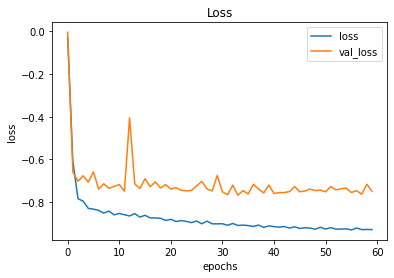

In [ ]:
import matplotlib.pyplot as plt

name = 'loss'

plt.title('Loss')
plt.plot(his[name],label=name)
plt.plot(his['val_' + name],label='val_' + name)
plt.xlabel('epochs')
plt.ylabel(name)
plt.legend()
plt.show()

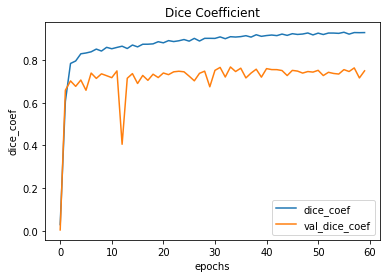

In [ ]:
name = 'dice_coef'

plt.title("Dice Coefficient")
plt.plot(his[name],label=name)
plt.plot(his['val_' + name],label='val_' + name)
plt.xlabel('epochs')
plt.ylabel(name)
plt.legend()
plt.show()

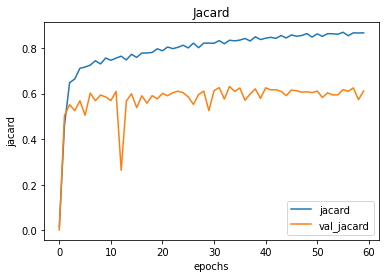

In [ ]:
name = 'jacard'

plt.title("Jacard")
plt.plot(his[name],label=name)
plt.plot(his['val_' + name],label='val_' + name)
plt.xlabel('epochs')
plt.ylabel(name)
plt.legend()
plt.show()

## Visualization 2

In [ ]:
his = {}

for name in ['loss','val_loss','dice_coef','val_dice_coef','jacard','val_jacard']:
  arr = []
  for plot in plot_history:
    arr += plot[name]
  his[name] = arr

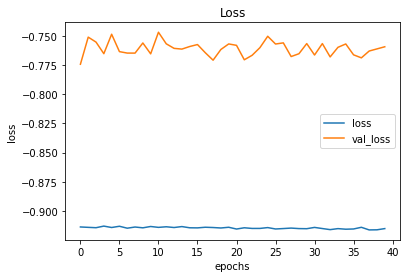

In [ ]:
import matplotlib.pyplot as plt

name = 'loss'

plt.title('Loss')
plt.plot(his[name],label=name)
plt.plot(his['val_' + name],label='val_' + name)
plt.xlabel('epochs')
plt.ylabel(name)
plt.legend()
plt.show()

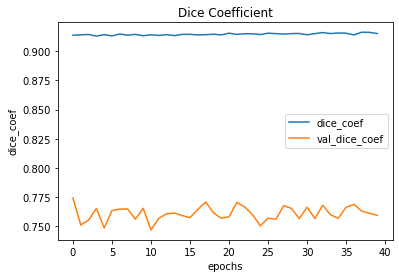

In [ ]:
name = 'dice_coef'

plt.title("Dice Coefficient")
plt.plot(his[name],label=name)
plt.plot(his['val_' + name],label='val_' + name)
plt.xlabel('epochs')
plt.ylabel(name)
plt.legend()
plt.show()

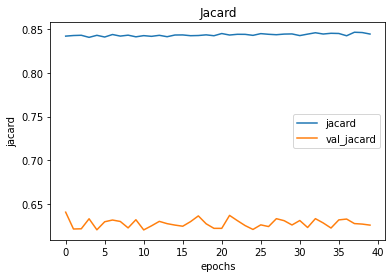

In [ ]:
name = 'jacard'

plt.title("Jacard")
plt.plot(his[name],label=name)
plt.plot(his['val_' + name],label='val_' + name)
plt.xlabel('epochs')
plt.ylabel(name)
plt.legend()
plt.show()

## Evaluation

In [ ]:
from keras.models import load_model

model = load_model("./checkpoints/model_-0.774.h5",compile=False)

In [ ]:
import os
from skimage import io
import numpy as np
from generator import *

test_dataset = './data/artery/valid_artery.h5'

BATCH_SIZE = 4

print('='*32)
test_gen = DatasetReader(dataset_path=test_dataset,batch_size=BATCH_SIZE)
test_epoch = test_gen.generator()
test_images, test_labels = [], []
for i in range(test_gen.getNumberOfTotalImages()):
  image, label = test_epoch.__next__()
  test_images.append(image)
  test_labels.append(label)
print('='*32)

The number of total images: 322


In [ ]:
test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)

In [ ]:
test_images.shape

(322, 512, 512, 1)

In [ ]:
output_images = model.predict(test_images, verbose=1)

11/11 [==============================] - 15s 857ms/step


In [ ]:
print('=' * 30)
print('Saving output to files...')
np.save('output.npy', output_images)
print('=' * 30)

Saving output to files...


In [ ]:
dir = 'predictions'
if not os.path.exists(dir):
	os.mkdir(dir)

i = 0
for image in output_images:
	image = (image[:, :, 0] * 255.).astype(np.uint8)
	ground_truth = (test_labels[i,:,:,0] * 255.).astype(np.uint8)
	origin = (test_images[i,:,:,0] *255.).astype(np.uint8)
	io.imsave(os.path.join(dir, str(i) + '_orgin.png'), origin)
	io.imsave(os.path.join(dir, str(i) + '_prediction.png'), image)
	io.imsave(os.path.join(dir, str(i) + '_groundtruth.png'), ground_truth)
	i += 1

print(f"The number of total images in test dataset are: {str(i)}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: predictions/0_prediction.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: predictions/0_groundtruth.png is a low contrast image
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: predictions/1_prediction.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: predictions/1_groundtruth.png is a low contrast image
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: predictions/2_prediction.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: predictions/2_groundtruth.png is a low cont

The number of total images in test dataset are: 322


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: predictions/319_prediction.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: predictions/319_groundtruth.png is a low contrast image
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: predictions/320_prediction.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: predictions/320_groundtruth.png is a low contrast image
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: predictions/321_prediction.png is a low contrast image
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: predictions/321_groundtruth.png i